# Задание 1: Модификация существующих моделей

## 1.0. Импорт необходимых библиотек. Подготовка данных с практики

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def make_regression_data(n=100, noise=0.2, source='random'):
    if source == "random":
        X = torch.randn(n, 1)
        w, b = -5, 10
        y = w * X + b + noise * torch.randn(n, 1)
        return X, y
    elif source == "diabetes":
        from sklearn.datasets import load_diabetes
        data = load_diabetes()
        X = torch.tensor(data["data"], dtype=torch.float32)
        y = torch.tensor(data["target"], dtype=torch.float32).unsqueeze(1) # (n, 1)
        return X, y
    else:
        raise ValueError("Unk source")

def make_classification_data(n_samples=100, n_classes=2, n_informative=2):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=n_informative,
        n_classes=n_classes,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=42
    )
    return torch.FloatTensor(X), torch.LongTensor(y)

def log_epoch(epoch, avg_loss, metrics=None):
    message = f'Epoch: {epoch}\tloss: {avg_loss:.4f}'
    if metrics is not None:
        for k, v in metrics.items():
            message += f'\t{k}: {v:.4f}'
        print(message)

## 1.1. Расширение линейной регрессии

### Обучение модели

In [13]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.linear(x)

X_train, y_train = make_regression_data(100)
X_val, y_val = make_regression_data(20)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

input_size = X_train.shape[1]
model = LinearRegression(input_size)

# Параметры регуляризации и ранней остановки
l1_lambda = 0.001  # Коэффициент для L1
l2_lambda = 0.01   # Коэффициент для L2, используем в параметре weight_decay в оттимизаторе
patience = 5       # Сколько раз мы можем ожидать лучшего значения функции потерь
best_val_loss = float('inf')
best_model_state = None
counter = 0

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=l2_lambda)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(1000):
    model.train()
    train_loss = 0
    for batch_x, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = model(batch_x)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        # Добавляем L1-регуляризацию
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        loss += l1_lambda * l1_reg
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val.unsqueeze(1))
            val_loss += loss.item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict().copy()
        torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, 'models/lin_reg_task_1.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}, best val_loss: {best_val_loss}')
            break
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch   0 | Train Loss: 126.9408 | Val Loss: 117.0780 | LR: 0.100000
Epoch  10 | Train Loss: 68.1887 | Val Loss: 59.0190 | LR: 0.100000
Epoch  20 | Train Loss: 36.9716 | Val Loss: 31.8235 | LR: 0.100000
Epoch  30 | Train Loss: 20.6725 | Val Loss: 22.8027 | LR: 0.100000
Epoch  40 | Train Loss: 23.2747 | Val Loss: 20.7663 | LR: 0.100000
Epoch  50 | Train Loss: 19.7881 | Val Loss: 20.5093 | LR: 0.100000
Epoch  60 | Train Loss: 18.1002 | Val Loss: 20.5356 | LR: 0.001000
Early stopping at epoch 69, best val_loss: 20.471757888793945


C:\Users\Михаил\AppData\Local\Temp\ipykernel_12492\3367299924.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


## 1.2. Расширение логистической регрессии

### Релизация метрик

In [67]:
def precision(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    """
    Вычисляет precision-метрику для бинарной и многоклассовой классификации.
    """
    if is_binary:
        true_pos = ((y_pred == 1) & (y_true == 1)).sum().float()
        false_pos = ((y_pred == 1) & (y_true == 0)).sum().float()
        return (true_pos / (true_pos + false_pos + 1e-10)).float().item()
        
    classes = torch.unique(y_true)
    precs = []
    for cls in classes:
        true_pos = ((y_pred == cls) & (y_true == cls)).sum().float()
        false_pos = ((y_pred == cls) & (y_true != cls)).sum().float()
        precision = true_pos / (true_pos + false_pos + 1e-10)
        precs.append(precision)
        
    torch_precs = torch.tensor(precs)
    return torch_precs.mean().float().item()

def recall(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    """
    Вычисляет recall-метрику для бинарной и многоклассовой классификации.
    """
    if is_binary:
        true_pos = ((y_pred == 1) & (y_true == 1)).sum().float()
        false_neg = ((y_pred == 0) & (y_true == 1)).sum().float()
        return (true_pos / (true_pos + false_neg + 1e-10)).float().item()

    classes = torch.unique(y_true)
    recalls = []
    for cls in classes:
        true_pos = ((y_pred == cls) & (y_true == cls)).sum().float()
        false_neg = ((y_pred != cls) & (y_true == cls)).sum().float()
        recalls.append(true_pos / (true_pos + false_neg + 1e-10))

    torch_recalls = torch.tensor(recalls)
    return torch_recalls.float().mean().item()

def f1_score(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    """
    Вычисляет метрику F1 для бинарной и многоклассовоой классификации.
    """
    precision_value = precision(y_true, y_pred, is_binary=is_binary)
    recall_value = recall(y_true, y_pred, is_binary=is_binary)
    return (2 * precision_value * recall_value) / (precision_value + recall_value + 1e-10)

def roc_auc_score(y_true: torch.Tensor, y_probs: torch.Tensor, is_binary: bool = True) -> float:
    """
    Вычисляет ROC-AUC-метрику для бинарной и многоклассовой классификации.
    """
    if is_binary:
        # Преобразуем одномерный тензор вероятностей для класса 1 в двумерный тензор 
        # с вероятностями для обоих классов и берём вероятности для класса 1
        y_scores = torch.stack([1 - y_probs, y_probs], dim=1)[:, 1]
        return _binary_roc_auc_score(y_true, y_scores)
        
        
    classes = torch.unique(y_true)
    auc_scores = []
    
    for cls in classes:
        # Текущий класс против всех остальных
        y_true_binary = (y_true == cls).long()
        
        # Берём вероятности для текущего класса
        y_scores = y_probs[:, cls]
        
        # Вычисляем ROC-AUC для бинарного случая
        auc_scores.append(_binary_roc_auc_score(y_true_binary, y_scores))
    
    # Усредняем AUC по всем классам
    return torch.mean(torch.tensor(auc_scores)).item()

def _binary_roc_auc_score(y_true, y_scores):
    thresholds = torch.unique(y_scores).flip(0)
    tpr = []
    fpr = []
    
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).long()
        tp = ((y_true == 1) & (y_pred == 1)).sum().float()
        fp = ((y_true == 0) & (y_pred == 1)).sum().float()
        fn = ((y_true == 1) & (y_pred == 0)).sum().float()
        tn = ((y_true == 0) & (y_pred == 0)).sum().float()
        
        tpr.append((tp / (tp + fn + 1e-10)).item())
        fpr.append((fp / (fp + tn + 1e-10)).item())
    
    # Вычисляем площадь методом трапеций
    auc = 0.0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc

def calculate_metrics(y_true, y_pred, y_probs, is_binary):
    metrics = {}
    
    metrics['precision'] = precision(y_true, y_pred, is_binary)
    metrics['recall'] = recall(y_true, y_pred, is_binary)
    metrics['f1_score'] = f1_score(y_true, y_pred, is_binary)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_probs, is_binary)

    return metrics

### Функция для построения confustion matrix

In [75]:
def plot_confusion_matrix(y_true, y_pred, class_names, filename):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.savefig(f'plots/{filename}.jpg')

### Расширенная модель

Epoch 1: Train Loss = 0.7874, Val Loss = 0.8971
Epoch 2: Train Loss = 0.7218, Val Loss = 0.8018
Epoch 3: Train Loss = 0.6781, Val Loss = 0.7164
Epoch 4: Train Loss = 0.6038, Val Loss = 0.6414
Epoch 5: Train Loss = 0.5751, Val Loss = 0.5778
Epoch 6: Train Loss = 0.5376, Val Loss = 0.5235
Epoch 7: Train Loss = 0.5058, Val Loss = 0.4804
Epoch 8: Train Loss = 0.4632, Val Loss = 0.4476
Epoch 9: Train Loss = 0.4474, Val Loss = 0.4234
Epoch 10: Train Loss = 0.4203, Val Loss = 0.4017
Epoch 11: Train Loss = 0.4177, Val Loss = 0.3823
Epoch 12: Train Loss = 0.4094, Val Loss = 0.3676
Epoch 13: Train Loss = 0.3848, Val Loss = 0.3580
Epoch 14: Train Loss = 0.3737, Val Loss = 0.3508
Epoch 15: Train Loss = 0.3589, Val Loss = 0.3427
Epoch 16: Train Loss = 0.3410, Val Loss = 0.3366
Epoch 17: Train Loss = 0.3223, Val Loss = 0.3292
Epoch 18: Train Loss = 0.3348, Val Loss = 0.3230
Epoch 19: Train Loss = 0.3218, Val Loss = 0.3197
Epoch 20: Train Loss = 0.3190, Val Loss = 0.3147
Epoch 21: Train Loss = 0.3083

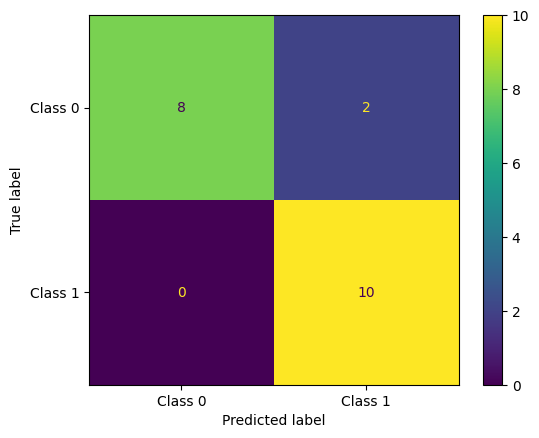

In [76]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

if __name__ == "__main__":
    X, y = make_classification(n_samples=120, n_features=10, n_classes=2, random_state=42)
    
    # Разделение данных
    n_classes = 2
    X_train, X_val = X[:100], X[100:]
    y_train, y_val = y[:100], y[100:]

    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.LongTensor(y_val)
    
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    input_dim = X_train.shape[1]
    output_dim = 1 if n_classes == 2 else n_classes
    model = LogisticRegression(input_dim, output_dim)
    is_binary = n_classes == 2
    
    criterion = nn.BCEWithLogitsLoss() if is_binary else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Настройки ранней остановки
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_metrics = None
    
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if is_binary:
                loss = criterion(outputs.squeeze(), labels.float())
            else:
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                
                if is_binary:
                    loss = criterion(outputs.squeeze(), labels.float())
                    probs = torch.sigmoid(outputs.squeeze())
                    preds = (probs > 0.5).long()
                else:
                    loss = criterion(outputs, labels)
                    probs = torch.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)
                
                val_loss += loss.item()
                all_preds.append(preds)
                all_probs.append(probs)
        
        avg_val_loss = val_loss / len(val_loader)
        all_preds = torch.cat(all_preds)
        all_probs = torch.cat(all_probs)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_metrics = calculate_metrics(y_val, all_preds, all_probs, is_binary)
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'metrics': best_metrics
            }, 'models/log_reg_task_1.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping на эпохе {epoch+1}. Best val_loss: {best_val_loss:.4f}")
                break
        
        print(f'Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}')
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        if is_binary:
            probs = torch.sigmoid(outputs.squeeze())
            final_preds = (probs > 0.5).long()
        else:
            probs = torch.softmax(outputs, dim=1)
            _, final_preds = torch.max(outputs, 1)
    
    # Сохраняем финальную confusion matrix
    class_names = [f'Class {i}' for i in range(n_classes)]
    plot_confusion_matrix(y_val.numpy(), final_preds.numpy(), 
                         class_names, f'log_reg_cm_task_1')
    
    print("\nФинальные метрики на валидации:")
    final_metrics = calculate_metrics(y_val, final_preds, probs, is_binary)
    for name, value in final_metrics.items():
        print(f"{name}: {value:.4f}")
